# Get data from google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [ ]:
import torch
from torchvision import datasets, transforms, utils
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Check CUDA Availability

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Dataset Paths

In [ ]:
#Don't forget to rename
fruit_train = '/content/drive/My Drive/notebook_data_and_output/dataset3/train'
fruit_test = '/content/drive/My Drive/notebook_data_and_output/dataset3/test'
data_dir = '/content/drive/My Drive/notebook_data_and_output/dataset3'
print(torch.cuda.device_count())

1


# Data Transformations

In [ ]:
data_transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.409], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.409], [0.229, 0.224, 0.225])
    ])
}

# Load datasets

In [ ]:
# Load datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transform[x]) for x in ['train', 'test']}

# Define class names

In [ ]:
class_names = image_datasets['train'].classes
print(class_names)

['Banana Good', 'Banana Rotten', 'Banana mild', 'Cucumber Good', 'Cucumber Mild', 'Cucumber Rotten', 'Grape Good', 'Grape Mild', 'Grape Rotten', 'Kaki Good', 'Kaki Mild', 'Kaki Rotten', 'Papaya Good', 'Papaya Mild', 'Papaya Rotten', 'Peach Good', 'Peach Mild', 'Peach Rotten', 'Pear Good', 'Pear Mild', 'Pear Rotten', 'Pepper Good', 'Pepper Mild', 'Pepper Rotten', 'Strawberry Mild', 'Strawberry Rotten', 'Tomato Good', 'Tomato Mild', 'Tomato Rotten', 'Watermelon Good', 'Watermelon Mild', 'Watermelon Rotten']


# Create Data Loaders

In [ ]:
data_loader = {x: torch.utils.data.DataLoader(image_datasets[x], shuffle=True, batch_size=32, num_workers=0) for x in ['train', 'test']}

# Display sample images

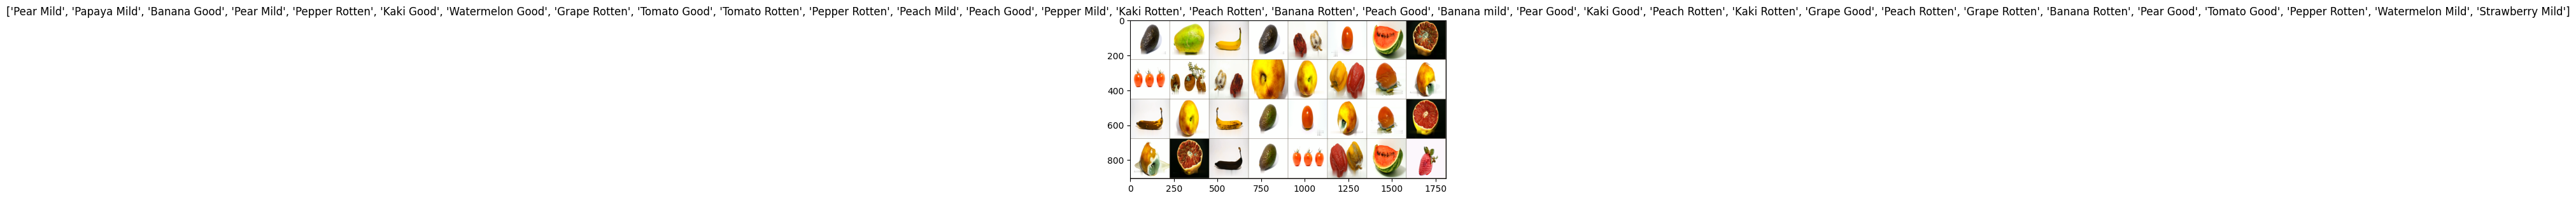

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(data_loader['train']))
out = utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

# Define Neural Network Architecture

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(512 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 32)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.dropout(F.max_pool2d(self.relu(self.bn1(self.conv1(x))), 2))
        x = self.dropout(F.max_pool2d(self.relu(self.bn2(self.conv2(x))), 2))
        x = self.dropout(F.max_pool2d(self.relu(self.bn3(self.conv3(x))), 2))
        x = self.dropout(F.max_pool2d(self.relu(self.bn4(self.conv4(x))), 2))
        x = torch.flatten(x, 1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

net = Net().to(device)  # Move the model to GPU

# Load model if it is available

In [ ]:
model_path = '/content/drive/My Drive/notebook_data_and_output/model3/fruit_classifier.pth'
if os.path.exists(model_path):
    net.load_state_dict(torch.load(model_path))
    print("Loaded saved model.")


# Training

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os


EPOCHS = 150
patience = 10  # Early stopping patience
i = 0

# Initialize optimizer and learning rate scheduler
optimizer = optim.Adam(net.parameters(), lr=0.001)
cross_el = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1)

best_loss = float('inf')
no_improvement_epochs = 0

# List to store loss values for plotting
loss_values = []

# File paths
paths = {
    "loss": "/content/drive/My Drive/notebook_data_and_output/metrics/Lossperepoch.txt",
    "accuracy": "/content/drive/My Drive/notebook_data_and_output/metrics/Accuracyperepoch.txt",
    "precision": "/content/drive/My Drive/notebook_data_and_output/metrics/Precisionperepoch.txt",
    "recall": "/content/drive/My Drive/notebook_data_and_output/metrics/Recallperepoch.txt",
    "f1": "/content/drive/My Drive/notebook_data_and_output/metrics/F1Scoreperepoch.txt",
    "roc_auc": "/content/drive/My Drive/notebook_data_and_output/metrics/ROCAUCperepoch.txt",
    "labels": "/content/drive/My Drive/notebook_data_and_output/metrics/Labels.txt",
    "preds": "/content/drive/My Drive/notebook_data_and_output/metrics/Preds.txt",
    "probs": "/content/drive/My Drive/notebook_data_and_output/metrics/Probs.txt"
}

# Training loop
for epoch in range(EPOCHS):
    print(f"Epoch: {epoch + 1}")
    net.train()  # Set the model to training mode
    running_loss = 0.0  # Initialize running loss for the epoch

    for batch_idx, data in enumerate(data_loader['train']):
        x, y = data[0].to(device), data[1].to(device)  # Move data to GPU
        optimizer.zero_grad()  # Clear gradients from the previous step
        output = net(x)  # Forward pass
        loss = cross_el(output, y)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters

        running_loss += loss.item()  # Accumulate loss
        i += 1  # Increment step counter

        # Print loss every 100 batches (for example)
        if (batch_idx + 1) % 100 == 0:
            print(f"Batch {batch_idx + 1}/{len(data_loader['train'])}, Loss: {loss.item()}")

    # Calculate and print average loss for the epoch
    average_loss = running_loss / len(data_loader['train'])
    loss_values.append(average_loss)  # Store loss value
    print(f"Average Loss for Epoch {epoch + 1}: {average_loss}")

    # Evaluation on the test set
    net.eval()  # Set the model to evaluation mode
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():  # No need to calculate gradients during evaluation
        for data in data_loader['test']:
            x, y = data[0].to(device), data[1].to(device)  # Move data to GPU
            output = net(x)  # Forward pass

            # Get predictions and probabilities
            _, preds = torch.max(output, 1)
            probs = torch.softmax(output, dim=1)  # Probabilities for all classes

            all_labels.extend(y.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')

    # Print metrics
    print(f"Accuracy for Epoch {epoch + 1}: {accuracy:.4f}")
    print(f"Precision for Epoch {epoch + 1}: {precision:.4f}")
    print(f"Recall for Epoch {epoch + 1}: {recall:.4f}")
    print(f"F1 Score for Epoch {epoch + 1}: {f1:.4f}")
    print(f"ROC AUC for Epoch {epoch + 1}: {roc_auc:.4f}")

    # Save metrics to files
    with open(paths["loss"], "a") as f:
        f.write(f"{epoch + 1}: {average_loss:.4f}\n")
    with open(paths["accuracy"], "a") as f:
        f.write(f"{epoch + 1}: {accuracy:.4f}\n")
    with open(paths["precision"], "a") as f:
        f.write(f"{epoch + 1}: {precision:.4f}\n")
    with open(paths["recall"], "a") as f:
        f.write(f"{epoch + 1}: {recall:.4f}\n")
    with open(paths["f1"], "a") as f:
        f.write(f"{epoch + 1}: {f1:.4f}\n")
    with open(paths["roc_auc"], "a") as f:
        f.write(f"{epoch + 1}: {roc_auc:.4f}\n")

    def append_formatted_data(file_path, data, epoch, header):
        try:
            file_exists = os.path.isfile(file_path)
            with open(file_path, 'a') as f:
                if not file_exists:
                    f.write(header + '\n')
                # Join data with commas and format it
                data_str = ', '.join(map(str, data))
                f.write(f"Epoch {epoch+1}: [{data_str}]\n")
                # Add a blank row to separate epochs
                f.write('\n')
        except IOError as e:
            print(f"Error writing to file {file_path}: {e}")

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    append_formatted_data(paths["labels"], all_labels, epoch, "Labels")
    append_formatted_data(paths["preds"], all_preds, epoch, "Predictions")
    append_formatted_data(paths["probs"], all_probs, epoch, "Probabilities")

    # Check for early stopping
    if average_loss < best_loss:
        best_loss = average_loss
        no_improvement_epochs = 0
        # Save the best model
        torch.save(net.state_dict(), model_path)
        print(f"Best model saved after epoch {epoch + 1}")
    else:
        no_improvement_epochs += 1
        print(f"No improvement for {no_improvement_epochs} epochs")

    # Adjust learning rate based on validation loss
    scheduler.step(average_loss)

    # Stop training if no improvement for several epochs
    if no_improvement_epochs >= patience:
        print("Early stopping triggered")
        break

Epoch: 1
Batch 100/293, Loss: 2.347356081008911
Batch 200/293, Loss: 1.5317496061325073
Average Loss for Epoch 1: 4.3597139093656185
Accuracy for Epoch 1: 0.4347
Precision for Epoch 1: 0.3043
Recall for Epoch 1: 0.4347
F1 Score for Epoch 1: 0.3378
ROC AUC for Epoch 1: 0.9616
Best model saved after epoch 1
Epoch: 2
Batch 100/293, Loss: 1.2137001752853394
Batch 200/293, Loss: 1.185688853263855
Average Loss for Epoch 2: 0.9913841875543367
Accuracy for Epoch 2: 0.5312
Precision for Epoch 2: 0.4273
Recall for Epoch 2: 0.5312
F1 Score for Epoch 2: 0.4504
ROC AUC for Epoch 2: 0.9825
Best model saved after epoch 2
Epoch: 3
Batch 100/293, Loss: 0.8363125324249268
Batch 200/293, Loss: 0.9901179075241089
Average Loss for Epoch 3: 0.921001164274411
Accuracy for Epoch 3: 0.6875
Precision for Epoch 3: 0.5833
Recall for Epoch 3: 0.6875
F1 Score for Epoch 3: 0.6146
ROC AUC for Epoch 3: 0.9791
Best model saved after epoch 3
Epoch: 4
Batch 100/293, Loss: 0.8278022408485413
Batch 200/293, Loss: 1.3464366

# Graphs

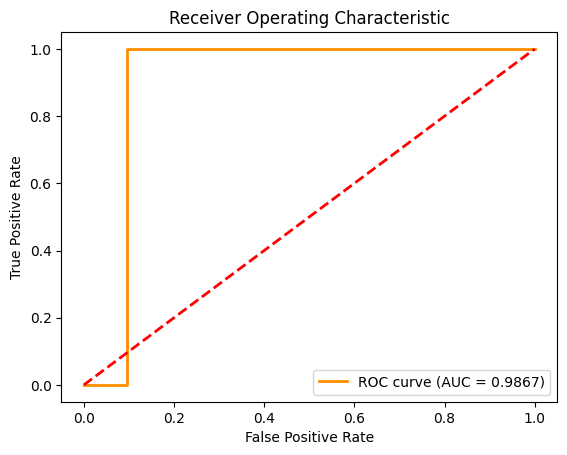

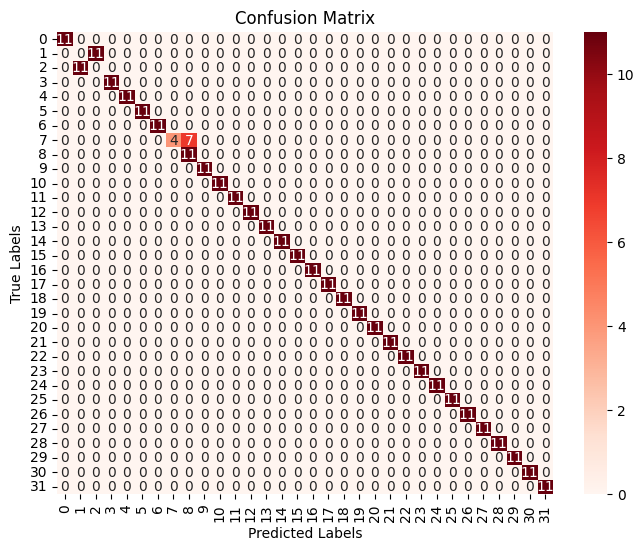

In [51]:
# Plot ROC curve after training
fpr, tpr, _ = roc_curve(np.array(all_labels), np.array(all_probs)[:, 1], pos_label=1)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot confusion matrix after training
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Evaluation

In [ ]:
k = 0
j = 0
correct = 0
total = 0
with torch.no_grad():
    for data in data_loader['test']:
        k += 1
        print("Test set: " + str(k))
        x, y = data[0].to(device), data[1].to(device)  # Move data to GPU
        output = net(x)
        for idx, i in enumerate(output):
            j += 1
            #print(j)
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1

print(f'Accuracy: {round(correct/total, 3)}')

Test set: 1
Test set: 2
Test set: 3
Test set: 4
Test set: 5
Test set: 6
Test set: 7
Test set: 8
Test set: 9
Test set: 10
Test set: 11
Accuracy: 0.918
